In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
from datasets import load_dataset

warnings.filterwarnings("ignore")

%matplotlib inline

plt.style.use('ggplot')

# Dataset

The [dataset](https://huggingface.co/datasets/petkopetkov/QABGB) has ~16k rows of questions, answers and context for them which are extracted from books translated to Bulgarian language. The context for most of the question-answer pairs is around 1000 characters.

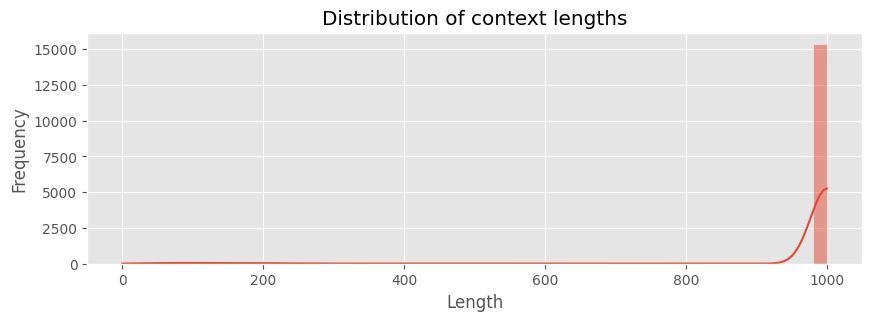

In [14]:
DATASET_PATH = "petkopetkov/QABGB"

data = load_dataset(DATASET_PATH)

train_data = data['train']

df = pd.DataFrame(train_data)

context_length = df['context'].apply(len)

plt.figure(figsize=(10, 3))
sns.histplot(context_length, bins=50, kde=True)
plt.title('Distribution of context lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

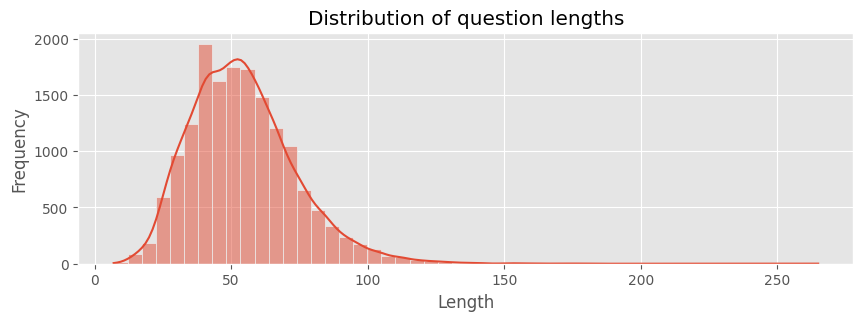

In [16]:
context_length = df['question'].apply(len)

plt.figure(figsize=(10, 3))
sns.histplot(context_length, bins=50, kde=True)
plt.title('Distribution of question lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

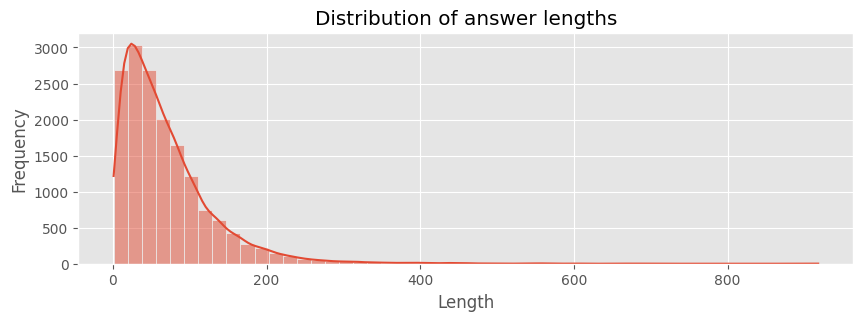

In [17]:
context_length = df['answer'].apply(len)

plt.figure(figsize=(10, 3))
sns.histplot(context_length, bins=50, kde=True)
plt.title('Distribution of answer lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
MODEL_NAME = "unsloth/Llama-3.2-1B-bnb-4bit"
MAX_SEQUENCE_LENGTH = 5020

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())
